# 📊 Analyse de Drift - Premier League MLOps

Ce notebook explore le **drift** entre différentes versions de données.

**Objectifs :**
- 🔍 Comparer v1 vs v2 visuellement
- 📈 Analyser les distributions de features
- 🎯 Vérifier le drift de la target
- 🤖 Décider si un réentraînement est nécessaire

---

## 📦 1. Imports et Configuration


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Taille des figures
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Imports réussis !")

✅ Imports réussis !


## 📂 2. Chargement des Données


In [2]:
# Chemins des données
v1_train = pd.read_parquet('../data/processed/v1/train.parquet')
v2_train = pd.read_parquet('../data/processed/v2/train.parquet')

print(f"📊 Version 1 (v1):")
print(f"   - Shape: {v1_train.shape}")
print(f"   - Colonnes: {v1_train.shape[1]}")
print(f"   - Samples: {v1_train.shape[0]}")

print(f"\n📊 Version 2 (v2):")
print(f"   - Shape: {v2_train.shape}")
print(f"   - Colonnes: {v2_train.shape[1]}")
print(f"   - Samples: {v2_train.shape[0]}")

print(f"\n📈 Différence:")
print(f"   - Samples: +{v2_train.shape[0] - v1_train.shape[0]} ({(v2_train.shape[0]/v1_train.shape[0]-1)*100:.1f}%)")

📊 Version 1 (v1):
   - Shape: (3480, 42)
   - Colonnes: 42
   - Samples: 3480

📊 Version 2 (v2):
   - Shape: (4060, 42)
   - Colonnes: 42
   - Samples: 4060

📈 Différence:
   - Samples: +580 (16.7%)


Code Aperçu données (Python)

In [3]:
# Afficher les premières lignes
print("🔍 Aperçu v1:")
display(v1_train.head(3))

print("\n🔍 Aperçu v2:")
display(v2_train.head(3))

🔍 Aperçu v1:


,season,team,gameweek,current_position,current_points,matches_played,wins,draws,losses,goals_for,...,form_last_5_goal_diff,avg_total_scoring_att,avg_ontarget_scoring_att,avg_total_pass,avg_accurate_pass,avg_total_tackle,avg_won_contest,avg_saves,avg_total_offside,target_final_points
0,2015-2016,Manchester City,10,-1.647509,-0.647039,-1.667188,-0.383380,-1.63403,-1.358438,-0.531706,...,1.184693,2.931846,3.458254,1.203737,1.265293,-0.411836,0.640739,-1.411704,-1.398283,66
1,2015-2016,Manchester City,11,-1.647509,-0.469554,-1.547023,-0.197512,-1.63403,-1.358438,-0.409061,...,0.986856,2.384782,2.801875,1.012497,1.055020,0.108480,0.501808,-1.671986,-1.398283,66
2,2015-2016,Manchester City,12,-1.647509,-0.410392,-1.426857,-0.197512,-1.28994,-1.358438,-0.409061,...,1.382530,2.465843,2.595322,1.175430,1.223554,0.056758,0.388137,-1.694479,-0.761229,66



🔍 Aperçu v2:


,season,team,gameweek,current_position,current_points,matches_played,wins,draws,losses,goals_for,...,form_last_5_goal_diff,avg_total_scoring_att,avg_ontarget_scoring_att,avg_total_pass,avg_accurate_pass,avg_total_tackle,avg_won_contest,avg_saves,avg_total_offside,target_final_points
0,2015-2016,Manchester City,10,-1.647509,-0.636591,-1.655036,-0.371074,-1.601937,-1.348282,-0.525146,...,1.157074,2.929493,3.460350,1.215562,1.268159,-0.377401,0.680913,-1.449370,-1.379444,66
1,2015-2016,Manchester City,11,-1.647509,-0.459546,-1.534909,-0.186424,-1.601937,-1.348282,-0.403465,...,0.963800,2.379474,2.801477,1.023882,1.057619,0.155614,0.536516,-1.717114,-1.379444,66
2,2015-2016,Manchester City,12,-1.647509,-0.400531,-1.414781,-0.186424,-1.265264,-1.348282,-0.403465,...,1.350348,2.460973,2.594139,1.187190,1.226367,0.102629,0.418372,-1.740252,-0.726740,66


## 🎯 3. Analyse de la Target (target_final_points)

In [4]:
# Statistiques descriptives de la target
target_col = 'target_final_points'

print("📊 Statistiques de la Target:")
print("\nVersion 1:")
print(v1_train[target_col].describe())

print("\nVersion 2:")
print(v2_train[target_col].describe())

📊 Statistiques de la Target:

Version 1:
count    3480.000000
mean       52.533333
std        17.994683
min        16.000000
25%        40.750000
50%        48.000000
75%        66.000000
max       100.000000
Name: target_final_points, dtype: float64

Version 2:
count    4060.000000
mean       52.542857
std        18.120246
min        16.000000
25%        40.000000
50%        49.000000
75%        66.000000
max       100.000000
Name: target_final_points, dtype: float64


Visualisation Target 

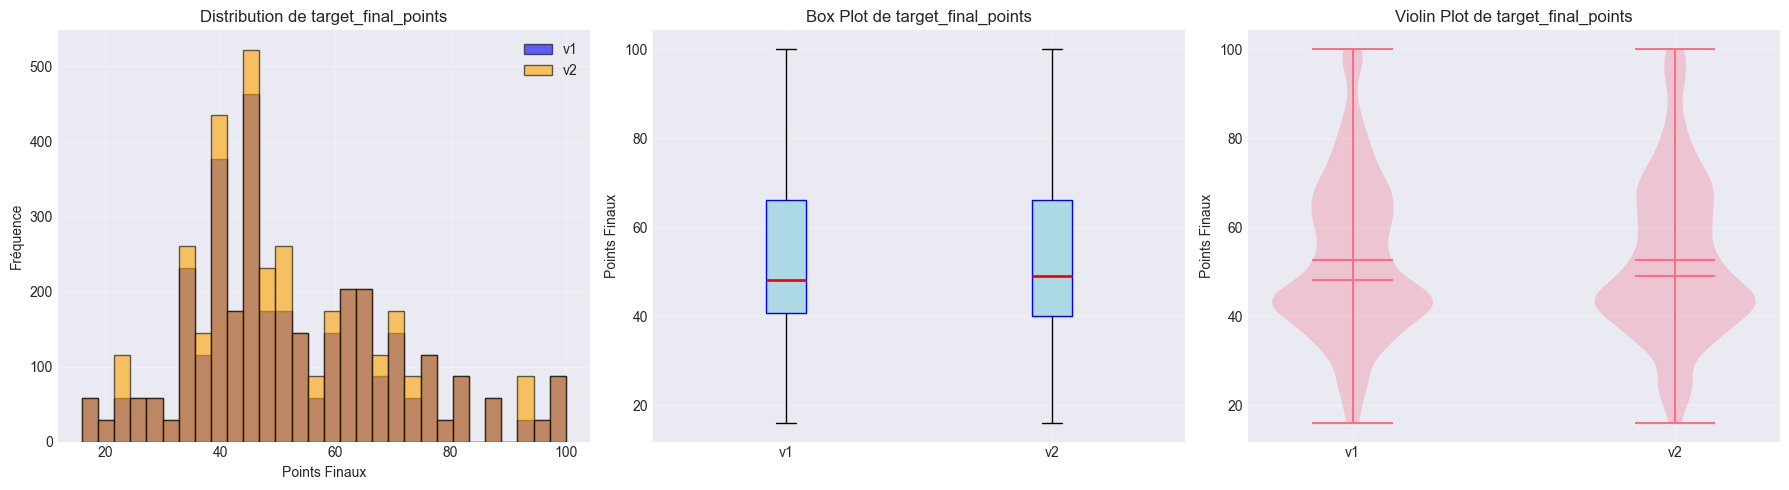


📈 Test de Kolmogorov-Smirnov:
   Statistique: 0.0167
   P-value: 0.6682
   Drift détecté: ❌ NON (seuil α=0.05)


In [5]:
# Comparaison visuelle de la target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogrammes
axes[0].hist(v1_train[target_col], bins=30, alpha=0.6, label='v1', color='blue', edgecolor='black')
axes[0].hist(v2_train[target_col], bins=30, alpha=0.6, label='v2', color='orange', edgecolor='black')
axes[0].set_xlabel('Points Finaux')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de target_final_points')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Box plots
data_to_plot = [v1_train[target_col], v2_train[target_col]]
axes[1].boxplot(data_to_plot, labels=['v1', 'v2'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Points Finaux')
axes[1].set_title('Box Plot de target_final_points')
axes[1].grid(True, alpha=0.3)

# 3. Violin plots
parts = axes[2].violinplot([v1_train[target_col], v2_train[target_col]], 
                            positions=[1, 2], showmeans=True, showmedians=True)
axes[2].set_xticks([1, 2])
axes[2].set_xticklabels(['v1', 'v2'])
axes[2].set_ylabel('Points Finaux')
axes[2].set_title('Violin Plot de target_final_points')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test statistique
statistic, p_value = stats.ks_2samp(v1_train[target_col], v2_train[target_col])
print(f"\n📈 Test de Kolmogorov-Smirnov:")
print(f"   Statistique: {statistic:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   Drift détecté: {'✅ OUI' if p_value < 0.05 else '❌ NON'} (seuil α=0.05)")

## 📊 4. Comparaison des Features Numériques

In [6]:
# Identifier les colonnes numériques (exclure target et colonnes catégorielles)
exclude_cols = ['season', 'team', 'target_final_points']
numeric_cols = [col for col in v1_train.columns 
                if col not in exclude_cols and v1_train[col].dtype in ['int64', 'float64']]

print(f"📊 Colonnes numériques à analyser: {len(numeric_cols)}")
print(f"\nExemples: {numeric_cols[:5]}")

📊 Colonnes numériques à analyser: 39

Exemples: ['gameweek', 'current_position', 'current_points', 'matches_played', 'wins']


Calcul Drift

In [7]:
# Fonction pour calculer le drift sur une colonne
def calculate_drift(v1_col, v2_col, threshold=0.05):
    """
    Calcule le drift entre deux colonnes avec le test KS
    """
    statistic, p_value = stats.ks_2samp(v1_col.dropna(), v2_col.dropna())
    drift_detected = p_value < threshold
    
    return {
        'statistic': statistic,
        'p_value': p_value,
        'drift_detected': drift_detected
    }

# Calculer le drift pour toutes les colonnes numériques
drift_results = {}

for col in numeric_cols:
    if col in v2_train.columns:
        drift_results[col] = calculate_drift(v1_train[col], v2_train[col])

# Créer un DataFrame des résultats
drift_df = pd.DataFrame(drift_results).T
drift_df = drift_df.sort_values('p_value')

print(f"\n📊 Résultats du drift sur {len(drift_df)} colonnes:")
print(f"   Features avec drift (p < 0.05): {drift_df['drift_detected'].sum()}")
print(f"   Features stables (p >= 0.05): {(~drift_df['drift_detected']).sum()}")
print(f"   Taux de drift: {drift_df['drift_detected'].sum() / len(drift_df) * 100:.1f}%")


📊 Résultats du drift sur 39 colonnes:
   Features avec drift (p < 0.05): True
   Features stables (p >= 0.05): True
   Taux de drift: 2.6%


Code Top Drift 

In [8]:
# Afficher les features avec le plus de drift
print("\n🔴 Top 10 Features avec le PLUS de drift (p-value la plus faible):")
display(drift_df.head(10))


🔴 Top 10 Features avec le PLUS de drift (p-value la plus faible):


,statistic,p_value,drift_detected
form_last_5_wins,0.300493,0.0,True
draws,0.134442,0.0,True
form_last_5_goals_against,0.133374,0.0,True
form_last_5_goals_for,0.126724,0.0,True
form_last_5_points,0.125821,0.0,True
failed_to_score,0.115353,0.0,True
clean_sheets,0.10899,0.0,True
away_goals_per_game,0.10078,0.0,True
form_last_5_goal_diff,0.084113,0.0,True
wins,0.083662,0.0,True


 Moins Drift 

In [9]:
# Afficher les features avec le moins de drift
print("\n🟢 Top 10 Features avec le MOINS de drift (p-value la plus élevée):")
display(drift_df.tail(10))


🟢 Top 10 Features avec le MOINS de drift (p-value la plus élevée):


,statistic,p_value,drift_detected
goals_conceded_per_game,0.024877,0.192983,False
avg_saves,0.021675,0.336849,False
avg_won_contest,0.019376,0.476127,False
avg_total_pass,0.015764,0.73351,False
avg_total_scoring_att,0.014778,0.801412,False
avg_accurate_pass,0.014614,0.812172,False
avg_total_tackle,0.01289,0.910108,False
matches_remaining,0.0,1.0,False
current_position,0.0,1.0,False
gameweek,0.0,1.0,False


## 📈 5. Visualisation des Features avec Drift

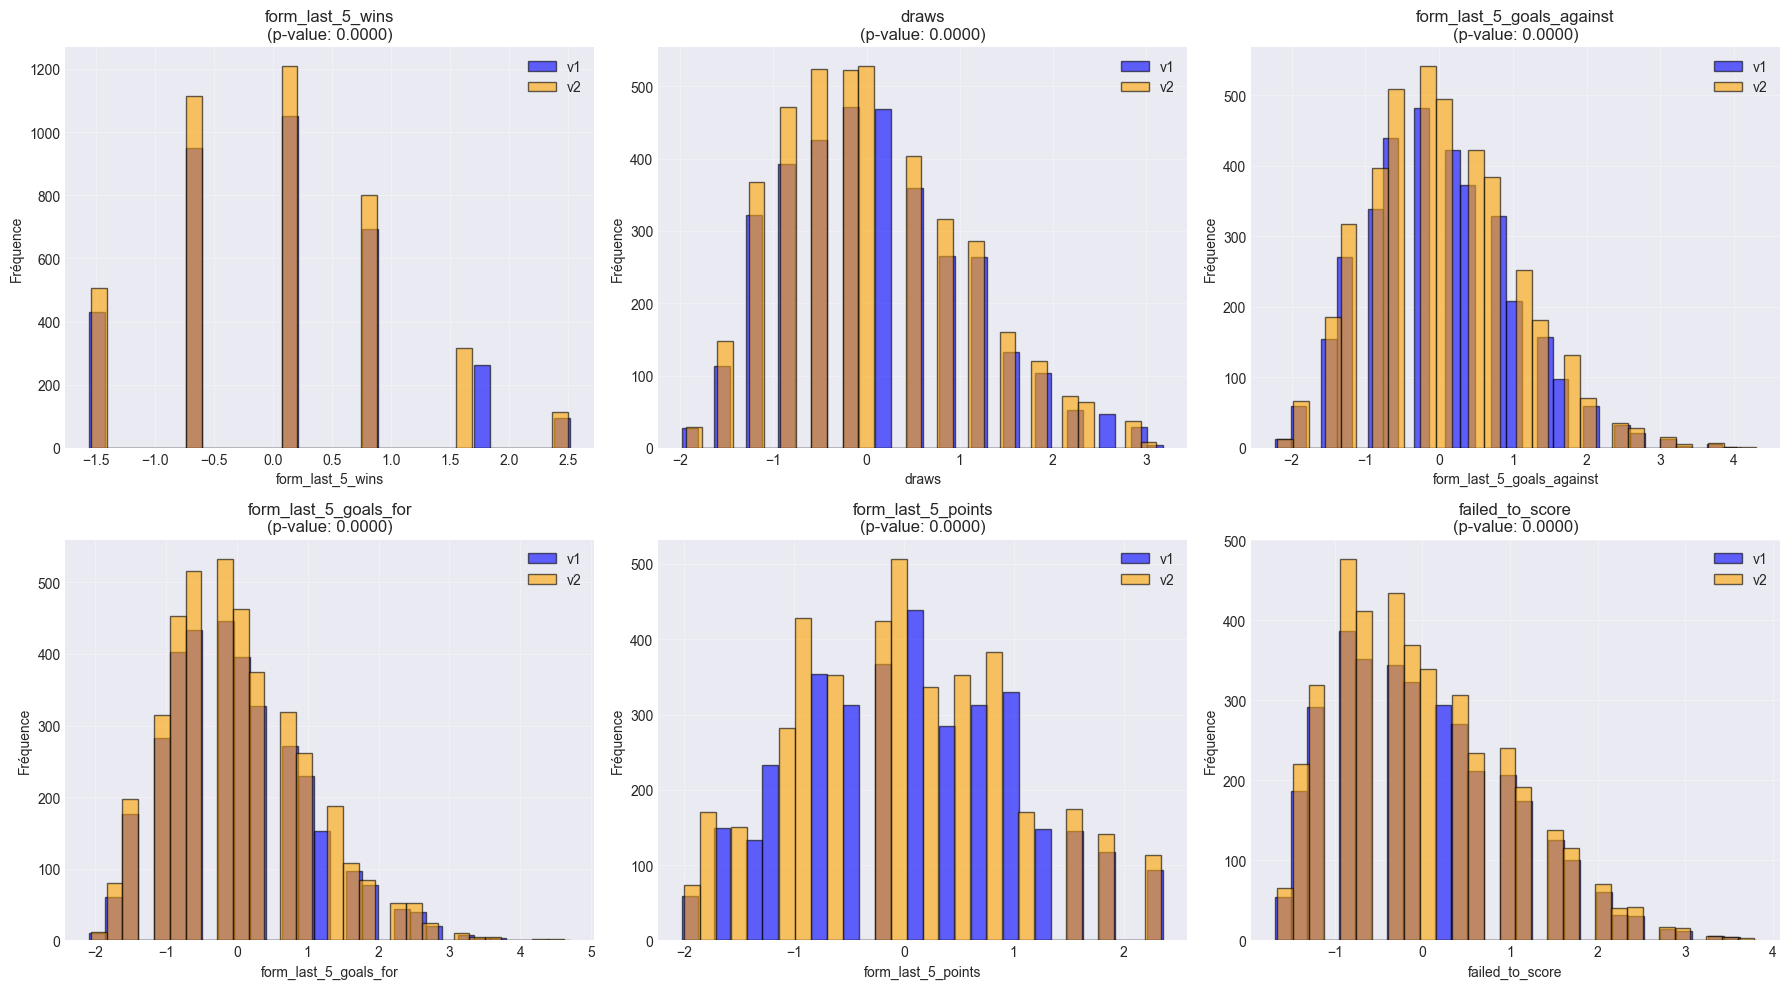

In [10]:
# Visualiser les 6 features avec le plus de drift
top_drift_features = drift_df[drift_df['drift_detected']].head(6).index.tolist()

if len(top_drift_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(top_drift_features):
        axes[idx].hist(v1_train[col], bins=30, alpha=0.6, label='v1', color='blue', edgecolor='black')
        axes[idx].hist(v2_train[col], bins=30, alpha=0.6, label='v2', color='orange', edgecolor='black')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Fréquence')
        axes[idx].set_title(f'{col}\n(p-value: {drift_df.loc[col, "p_value"]:.4f})')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ Aucune feature avec drift détecté !")

## 🎯 6. Comparaison des Statistiques Clés

In [11]:
# Comparer les moyennes de quelques features importantes
important_features = ['current_points', 'goals_for', 'goals_against', 'win_rate', 
                       'points_per_game', 'form_last_5_points']

comparison_data = []

for col in important_features:
    if col in v1_train.columns and col in v2_train.columns:
        comparison_data.append({
            'Feature': col,
            'v1_mean': v1_train[col].mean(),
            'v2_mean': v2_train[col].mean(),
            'v1_std': v1_train[col].std(),
            'v2_std': v2_train[col].std(),
            'diff_%': ((v2_train[col].mean() - v1_train[col].mean()) / v1_train[col].mean() * 100)
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Comparaison des Features Importantes:")
display(comparison_df)


📊 Comparaison des Features Importantes:


,Feature,v1_mean,v2_mean,v1_std,v2_std,diff_%
0,current_points,1.715103e-16,1.610097e-16,1.000144,1.000123,-6.122449
1,goals_for,-2.021372e-16,-2.170131e-16,1.000144,1.000123,7.359307
2,goals_against,-2.143879e-16,-2.380143e-16,1.000144,1.000123,11.020408
3,win_rate,5.308653e-17,-2.240135e-16,1.000144,1.000123,-521.978022
4,points_per_game,-4.594026e-16,9.100547e-17,1.000144,1.000123,-119.809524
5,form_last_5_points,4.696116e-17,4.200253e-17,1.000144,1.000123,-10.559006


Graphique Comparaison 

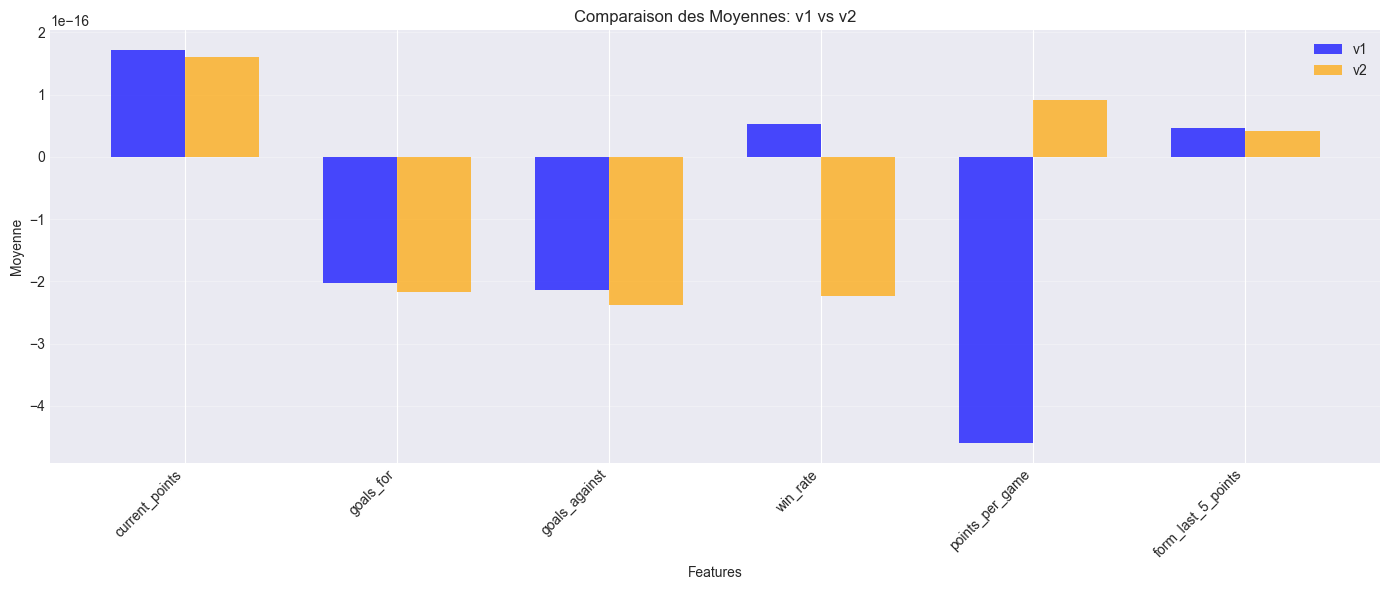

In [12]:
# Graphique de comparaison des moyennes
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['v1_mean'], width, label='v1', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, comparison_df['v2_mean'], width, label='v2', color='orange', alpha=0.7)

ax.set_xlabel('Features')
ax.set_ylabel('Moyenne')
ax.set_title('Comparaison des Moyennes: v1 vs v2')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 📉 7. Analyse des Corrélations

In [13]:
# Calculer les corrélations avec la target
v1_corr = v1_train[numeric_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)
v2_corr = v2_train[numeric_cols + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)

# Comparer les corrélations
corr_comparison = pd.DataFrame({
    'v1_corr': v1_corr,
    'v2_corr': v2_corr,
    'diff': v2_corr - v1_corr
}).sort_values('diff', key=abs, ascending=False)

print("\n📊 Top 10 Features avec le PLUS grand changement de corrélation:")
display(corr_comparison.head(10))


📊 Top 10 Features avec le PLUS grand changement de corrélation:


,v1_corr,v2_corr,diff
avg_total_tackle,-0.085609,-0.132500,-0.046891
clean_sheet_rate,0.631985,0.666772,0.034787
clean_sheets,0.486302,0.519249,0.032946
avg_won_contest,0.411286,0.378767,-0.032519
avg_accurate_pass,0.724065,0.742197,0.018132
avg_total_pass,0.728476,0.744484,0.016008
btts_rate,0.767635,0.754516,-0.013119
form_last_5_goals_against,-0.482464,-0.493269,-0.010805
avg_ontarget_scoring_att,0.799888,0.809676,0.009787
avg_saves,-0.541404,-0.550708,-0.009305


Code Visualisation Corrélations

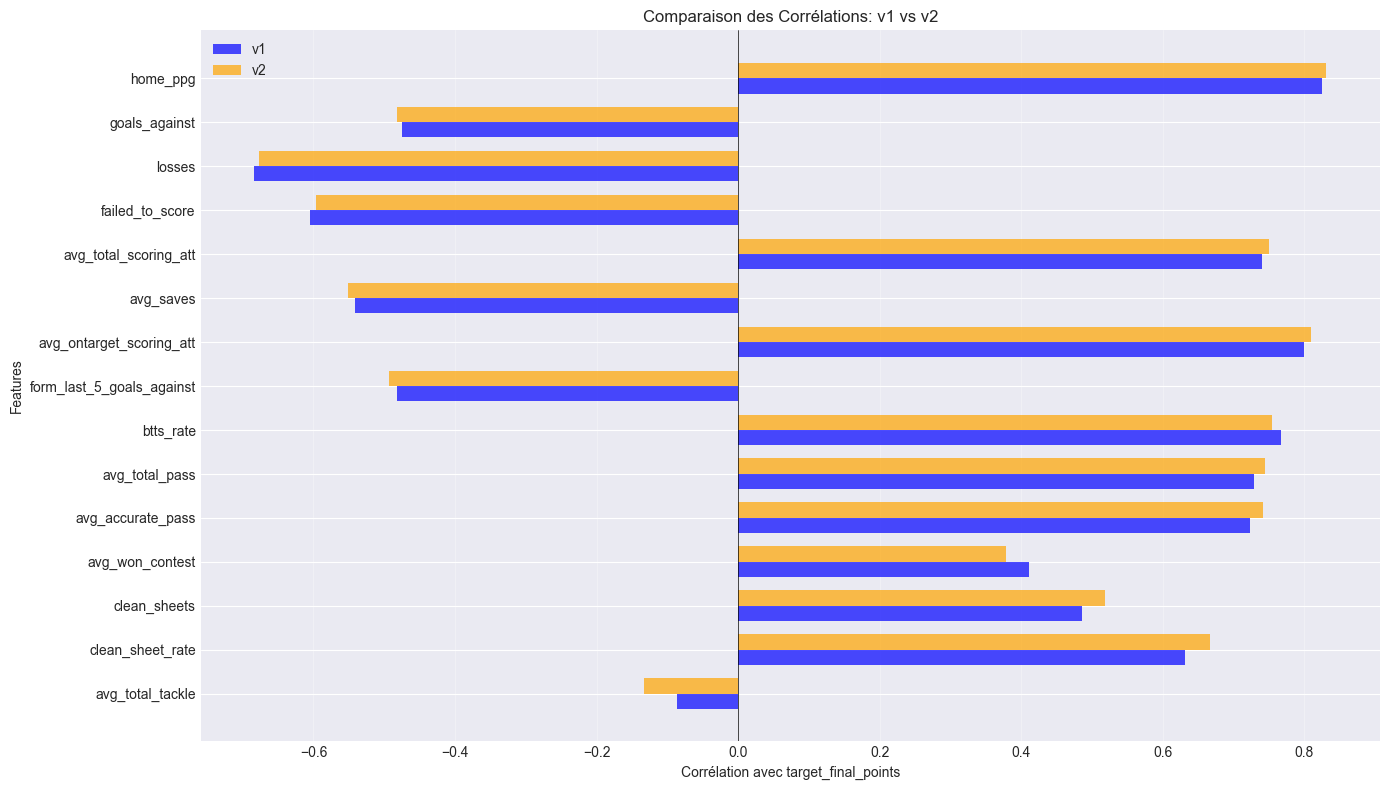

In [14]:
# Visualiser les changements de corrélation
top_corr_changes = corr_comparison.head(15)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_corr_changes))
width = 0.35

bars1 = ax.barh(x - width/2, top_corr_changes['v1_corr'], width, label='v1', color='blue', alpha=0.7)
bars2 = ax.barh(x + width/2, top_corr_changes['v2_corr'], width, label='v2', color='orange', alpha=0.7)

ax.set_ylabel('Features')
ax.set_xlabel('Corrélation avec target_final_points')
ax.set_title('Comparaison des Corrélations: v1 vs v2')
ax.set_yticks(x)
ax.set_yticklabels(top_corr_changes.index)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

## 🤖 8. Décision de Réentraînement

In [15]:
# Charger la décision depuis le fichier JSON
try:
    with open('../reports/drift/latest_decision.json', 'r') as f:
        decision_data = json.load(f)
    
    print("📋 Décision de Réentraînement (depuis drift_detection.py):")
    print("="*60)
    
    metrics = decision_data['metrics']
    decision = decision_data['decision']
    
    print(f"\n🎯 Métriques:")
    print(f"   Drift réel: {decision.get('actual_drift_rate', 0):.1%}")
    print(f"   Features avec drift: {decision.get('num_drifted_features', 0)}/{decision.get('num_total_features', 0)}")
    print(f"   Target drift: {'✅ OUI' if metrics.get('target_drift', {}).get('drift_detected') else '❌ NON'}")
    
    print(f"\n🤖 Recommandation:")
    if decision['retrain_recommended']:
        print(f"   🔴 RÉENTRAÎNEMENT RECOMMANDÉ")
        print(f"   Sévérité: {decision['severity'].upper()}")
        print(f"\n   Raisons:")
        for reason in decision['reasons']:
            print(f"      • {reason}")
    else:
        print(f"   🟢 MODÈLE OK - Pas besoin de réentraîner")
        print(f"   Sévérité: {decision['severity'].upper()}")
    
    print("\n" + "="*60)
    
except FileNotFoundError:
    print("⚠️  Fichier de décision non trouvé. Exécutez d'abord drift_detection.py")

📋 Décision de Réentraînement (depuis drift_detection.py):

🎯 Métriques:
   Drift réel: 0.0%
   Features avec drift: 0/42
   Target drift: ❌ NON

🤖 Recommandation:
   🟢 MODÈLE OK - Pas besoin de réentraîner
   Sévérité: LOW



## 📊 9. Synthèse Finale

In [16]:
# Créer un résumé visuel
print("\n" + "="*60)
print("📊 SYNTHÈSE DE L'ANALYSE DE DRIFT")
print("="*60)

print(f"\n📂 Données:")
print(f"   v1: {v1_train.shape[0]} samples, {v1_train.shape[1]} colonnes")
print(f"   v2: {v2_train.shape[0]} samples, {v2_train.shape[1]} colonnes")
print(f"   Augmentation: +{v2_train.shape[0] - v1_train.shape[0]} samples ({(v2_train.shape[0]/v1_train.shape[0]-1)*100:.1f}%)")

print(f"\n🎯 Target (target_final_points):")
target_drift_result = calculate_drift(v1_train[target_col], v2_train[target_col])
print(f"   Drift détecté: {'✅ OUI' if target_drift_result['drift_detected'] else '❌ NON'}")
print(f"   P-value: {target_drift_result['p_value']:.4f}")
print(f"   Moyenne v1: {v1_train[target_col].mean():.2f}")
print(f"   Moyenne v2: {v2_train[target_col].mean():.2f}")
print(f"   Différence: {abs(v2_train[target_col].mean() - v1_train[target_col].mean()):.2f}")

print(f"\n📊 Features:")
print(f"   Total analysées: {len(drift_df)}")
print(f"   Avec drift (p < 0.05): {drift_df['drift_detected'].sum()}")
print(f"   Stables (p >= 0.05): {(~drift_df['drift_detected']).sum()}")
print(f"   Taux de drift: {drift_df['drift_detected'].sum() / len(drift_df) * 100:.1f}%")

if drift_df['drift_detected'].sum() > 0:
    print(f"\n⚠️  Features avec drift:")
    for col in drift_df[drift_df['drift_detected']].index[:5]:
        print(f"      • {col} (p={drift_df.loc[col, 'p_value']:.4f})")

print(f"\n🤖 Recommandation Finale:")
total_drift_rate = drift_df['drift_detected'].sum() / len(drift_df)
if total_drift_rate > 0.3 or target_drift_result['drift_detected']:
    print(f"   🔴 RÉENTRAÎNEMENT RECOMMANDÉ")
    if target_drift_result['drift_detected']:
        print(f"      Raison: Target drift détecté")
    if total_drift_rate > 0.3:
        print(f"      Raison: {total_drift_rate:.1%} des features ont drifté (seuil: 30%)")
else:
    print(f"   🟢 MODÈLE OK - Pas besoin de réentraîner")
    print(f"      Le drift est minimal et acceptable")

print("\n" + "="*60)


📊 SYNTHÈSE DE L'ANALYSE DE DRIFT

📂 Données:
   v1: 3480 samples, 42 colonnes
   v2: 4060 samples, 42 colonnes
   Augmentation: +580 samples (16.7%)

🎯 Target (target_final_points):
   Drift détecté: ❌ NON
   P-value: 0.6682
   Moyenne v1: 52.53
   Moyenne v2: 52.54
   Différence: 0.01

📊 Features:
   Total analysées: 39
   Avec drift (p < 0.05): True
   Stables (p >= 0.05): True
   Taux de drift: 2.6%

⚠️  Features avec drift:
      • form_last_5_wins (p=0.0000)
      • draws (p=0.0000)
      • form_last_5_goals_against (p=0.0000)
      • form_last_5_goals_for (p=0.0000)
      • form_last_5_points (p=0.0000)

🤖 Recommandation Finale:
   🟢 MODÈLE OK - Pas besoin de réentraîner
      Le drift est minimal et acceptable



## 🎨 10. Dashboard Visuel

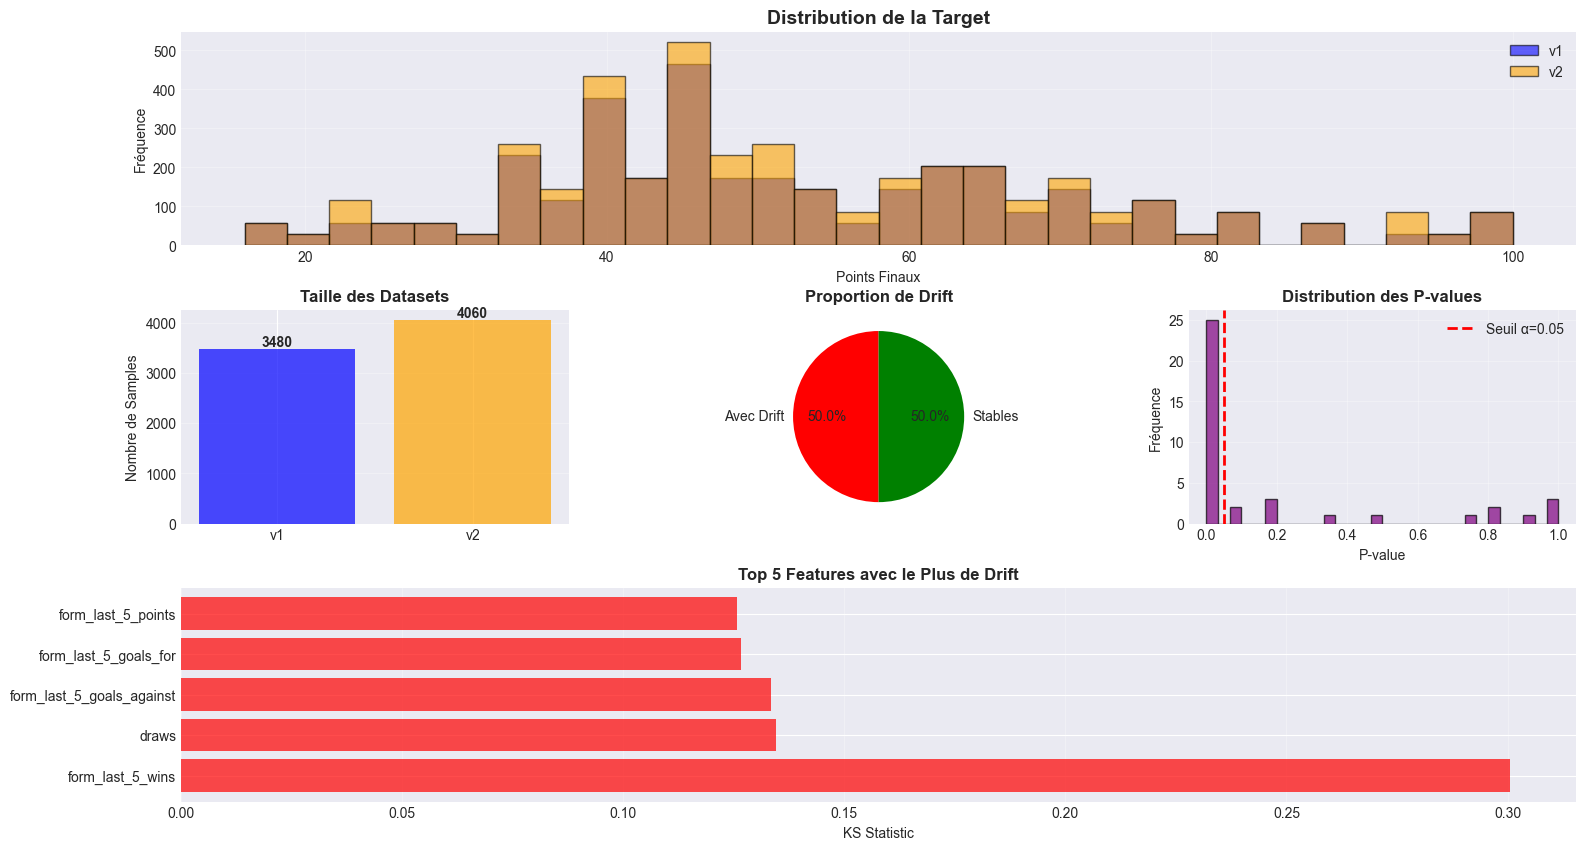

In [17]:
# Créer un dashboard compact
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribution de la target
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(v1_train[target_col], bins=30, alpha=0.6, label='v1', color='blue', edgecolor='black')
ax1.hist(v2_train[target_col], bins=30, alpha=0.6, label='v2', color='orange', edgecolor='black')
ax1.set_xlabel('Points Finaux')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution de la Target', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Nombre de samples
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(['v1', 'v2'], [v1_train.shape[0], v2_train.shape[0]], color=['blue', 'orange'], alpha=0.7)
ax2.set_ylabel('Nombre de Samples')
ax2.set_title('Taille des Datasets', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate([v1_train.shape[0], v2_train.shape[0]]):
    ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')

# 3. Features avec drift
ax3 = fig.add_subplot(gs[1, 1])
drift_counts = [drift_df['drift_detected'].sum(), (~drift_df['drift_detected']).sum()]
colors = ['red', 'green']
ax3.pie(drift_counts, labels=['Avec Drift', 'Stables'], autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('Proportion de Drift', fontsize=12, fontweight='bold')

# 4. P-values distribution
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(drift_df['p_value'], bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='Seuil α=0.05')
ax4.set_xlabel('P-value')
ax4.set_ylabel('Fréquence')
ax4.set_title('Distribution des P-values', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Top features avec drift
ax5 = fig.add_subplot(gs[2, :])
if drift_df['drift_detected'].sum() > 0:
    top_5_drift = drift_df[drift_df['drift_detected']].head(5)
    ax5.barh(range(len(top_5_drift)), top_5_drift['statistic'], color='red', alpha=0.7)
    ax5.set_yticks(range(len(top_5_drift)))
    ax5.set_yticklabels(top_5_drift.index)
    ax5.set_xlabel('KS Statistic')
    ax5.set_title('Top 5 Features avec le Plus de Drift', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
else:
    ax5.text(0.5, 0.5, '✅ Aucune feature avec drift détecté', 
             ha='center', va='center', fontsize=14, fontweight='bold')
    ax5.set_xlim(0, 1)
    ax5.set_ylim(0, 1)
    ax5.axis('off')

plt.tight_layout()
plt.show()

## 💾 11. Exporter les Résultats

In [18]:
# Sauvegarder le rapport de drift dans un CSV
output_path = Path('../reports/drift/')
output_path.mkdir(parents=True, exist_ok=True)

# 1. Sauvegarder les résultats de drift
drift_df.to_csv(output_path / 'drift_features_analysis.csv')
print(f"✅ Résultats de drift sauvegardés: {output_path / 'drift_features_analysis.csv'}")

# 2. Sauvegarder la comparaison des statistiques
comparison_df.to_csv(output_path / 'features_comparison.csv', index=False)
print(f"✅ Comparaison des features sauvegardée: {output_path / 'features_comparison.csv'}")

# 3. Sauvegarder la comparaison des corrélations
corr_comparison.to_csv(output_path / 'correlation_changes.csv')
print(f"✅ Changements de corrélation sauvegardés: {output_path / 'correlation_changes.csv'}")

print("\n📁 Tous les fichiers sont dans: reports/drift/")

✅ Résultats de drift sauvegardés: ..\reports\drift\drift_features_analysis.csv
✅ Comparaison des features sauvegardée: ..\reports\drift\features_comparison.csv
✅ Changements de corrélation sauvegardés: ..\reports\drift\correlation_changes.csv

📁 Tous les fichiers sont dans: reports/drift/


## 🎓 12. Conclusions et Recommandations

In [19]:
print("\n" + "="*70)
print("🎓 CONCLUSIONS ET RECOMMANDATIONS")
print("="*70)

# Analyser la situation
num_drifted = drift_df['drift_detected'].sum()
drift_rate = num_drifted / len(drift_df)
target_drifted = target_drift_result['drift_detected']

print(f"\n📊 Résumé:")
print(f"   • {num_drifted}/{len(drift_df)} features ont drifté ({drift_rate:.1%})")
print(f"   • Target drift: {'✅ OUI' if target_drifted else '❌ NON'}")
print(f"   • Augmentation des données: +{v2_train.shape[0] - v1_train.shape[0]} samples")

print(f"\n🎯 Recommandations:")

if target_drifted:
    print("\n   🔴 CRITIQUE: Target drift détecté !")
    print("      → RÉENTRAÎNEMENT OBLIGATOIRE")
    print("      → La distribution des points finaux a changé")
    print("      → Votre modèle actuel ne sera pas fiable")
elif drift_rate > 0.5:
    print("\n   🔴 ÉLEVÉ: Plus de 50% des features ont drifté")
    print("      → RÉENTRAÎNEMENT FORTEMENT RECOMMANDÉ")
    print("      → Les données ont significativement changé")
    print("      → Risque de dégradation des performances")
elif drift_rate > 0.3:
    print("\n   🟡 MODÉRÉ: 30-50% des features ont drifté")
    print("      → RÉENTRAÎNEMENT RECOMMANDÉ")
    print("      → Testez d'abord le modèle actuel sur v2")
    print("      → Si les performances baissent, réentraînez")
elif drift_rate > 0.1:
    print("\n   🟢 FAIBLE: 10-30% des features ont drifté")
    print("      → Réentraînement OPTIONNEL")
    print("      → Surveillez les performances en production")
    print("      → Considérez un réentraînement dans le futur")
else:
    print("\n   ✅ MINIMAL: Moins de 10% des features ont drifté")
    print("      → MODÈLE OK, pas besoin de réentraîner")
    print("      → Le modèle actuel reste fiable")
    print("      → Continuez à monitorer le drift régulièrement")

print(f"\n💡 Actions suggérées:")
if target_drifted or drift_rate > 0.3:
    print("   1. Réentraîner le modèle sur les données v2")
    print("   2. Comparer les performances: ancien modèle vs nouveau")
    print("   3. Valider sur le test set v2")
    print("   4. Déployer le nouveau modèle si meilleur")
else:
    print("   1. Tester le modèle actuel sur v2")
    print("   2. Comparer les métriques (MAE, RMSE, R²)")
    print("   3. Si performances OK, garder le modèle actuel")
    print("   4. Sinon, considérer un réentraînement")

print(f"\n📅 Monitoring:")
print("   • Exécutez cette analyse à chaque nouvelle version de données")
print("   • Définissez des alertes si drift > seuil")
print("   • Automatisez le processus dans votre pipeline MLOps")

print("\n" + "="*70)


🎓 CONCLUSIONS ET RECOMMANDATIONS

📊 Résumé:
   • True/39 features ont drifté (2.6%)
   • Target drift: ❌ NON
   • Augmentation des données: +580 samples

🎯 Recommandations:

   ✅ MINIMAL: Moins de 10% des features ont drifté
      → MODÈLE OK, pas besoin de réentraîner
      → Le modèle actuel reste fiable
      → Continuez à monitorer le drift régulièrement

💡 Actions suggérées:
   1. Tester le modèle actuel sur v2
   2. Comparer les métriques (MAE, RMSE, R²)
   3. Si performances OK, garder le modèle actuel
   4. Sinon, considérer un réentraînement

📅 Monitoring:
   • Exécutez cette analyse à chaque nouvelle version de données
   • Définissez des alertes si drift > seuil
   • Automatisez le processus dans votre pipeline MLOps

